c:\Users\cjogi\AppData\Local\pypoetry\Cache\virtualenvs\atd-walker-package-VDrAW----py3.12\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded SHAP values with shape: (50, 17, 6)
States shape: (50, 17)
Feature names: ['torso_height', 'torso_angle', 'left_thigh_angle', 'left_knee_angle', 'left_ankle_angle', 'right_thigh_angle', 'right_knee_angle', 'right_ankle_angle', 'left_thigh_velocity', 'left_knee_velocity', 'left_ankle_velocity', 'right_thigh_velocity', 'right_knee_velocity', 'right_ankle_velocity', 'horizontal_velocity', 'vertical_velocity', 'angular_velocity']
Displaying SHAP Summary for Action Dimension 0


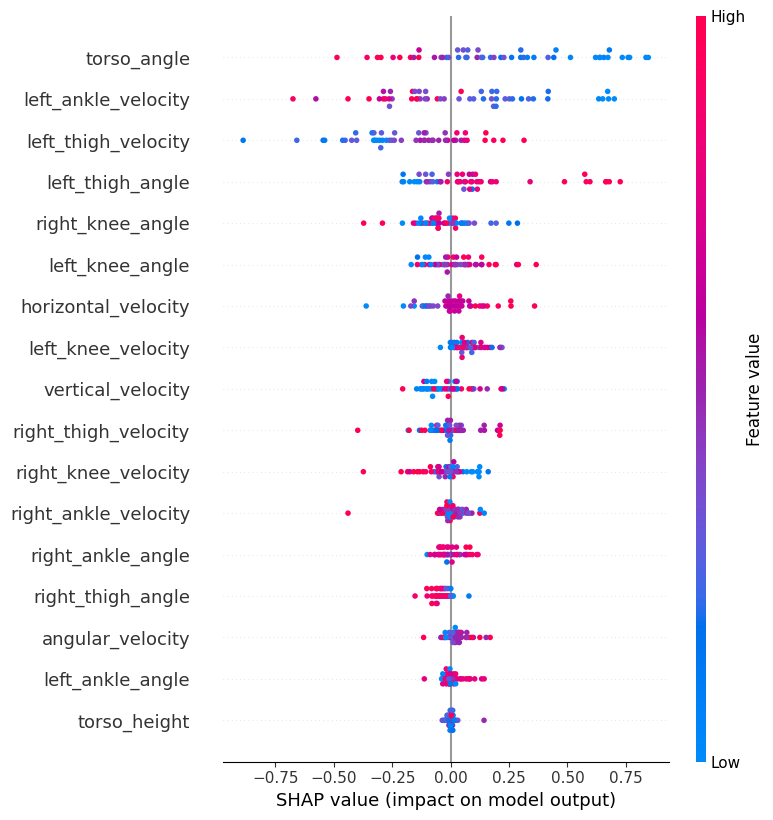

Displaying SHAP Summary for Action Dimension 1


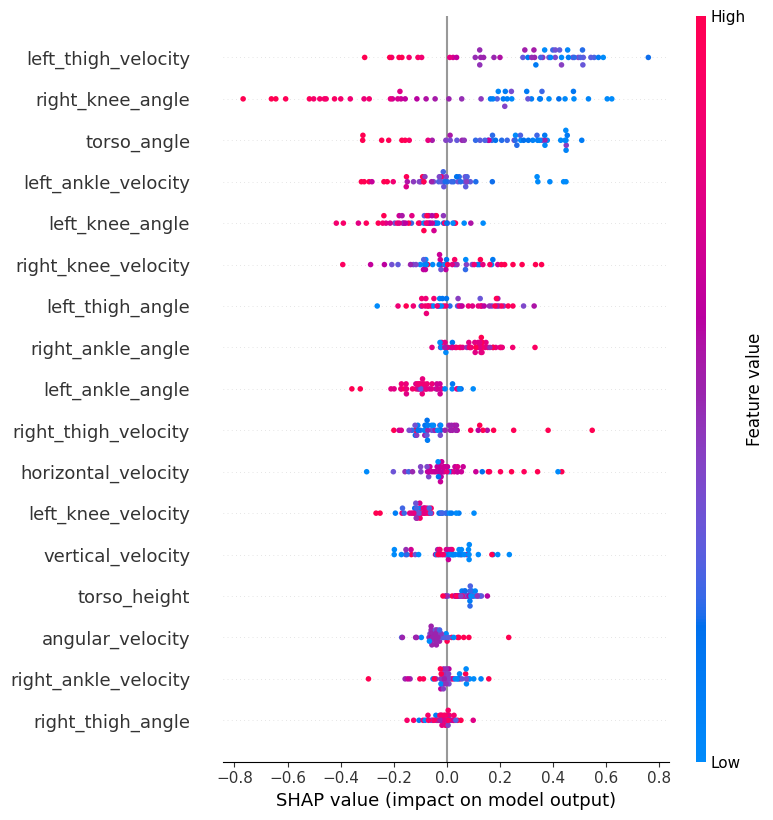

Displaying SHAP Summary for Action Dimension 2


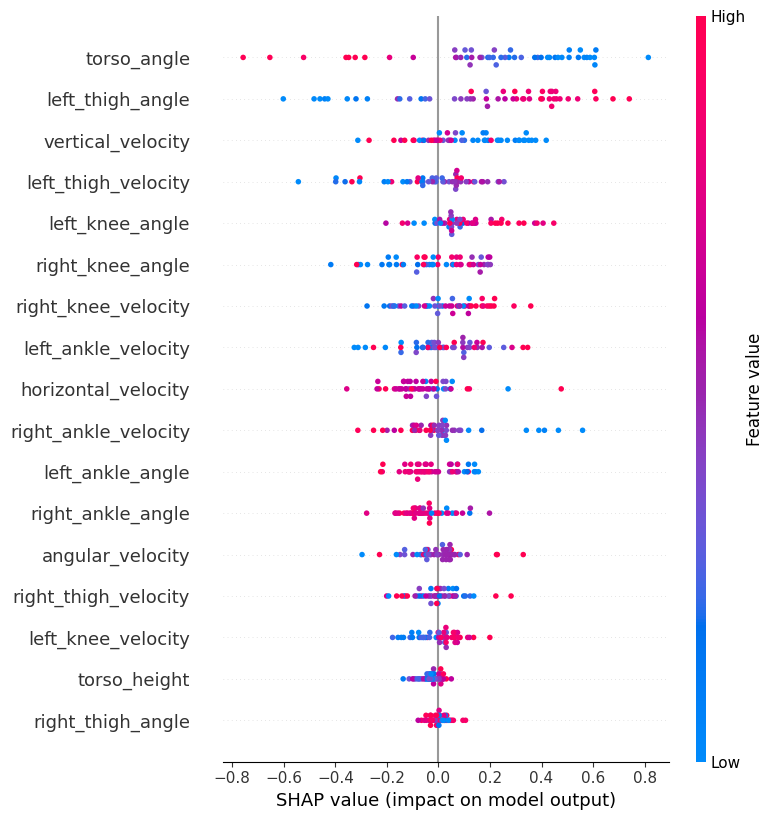

Displaying SHAP Summary for Action Dimension 3


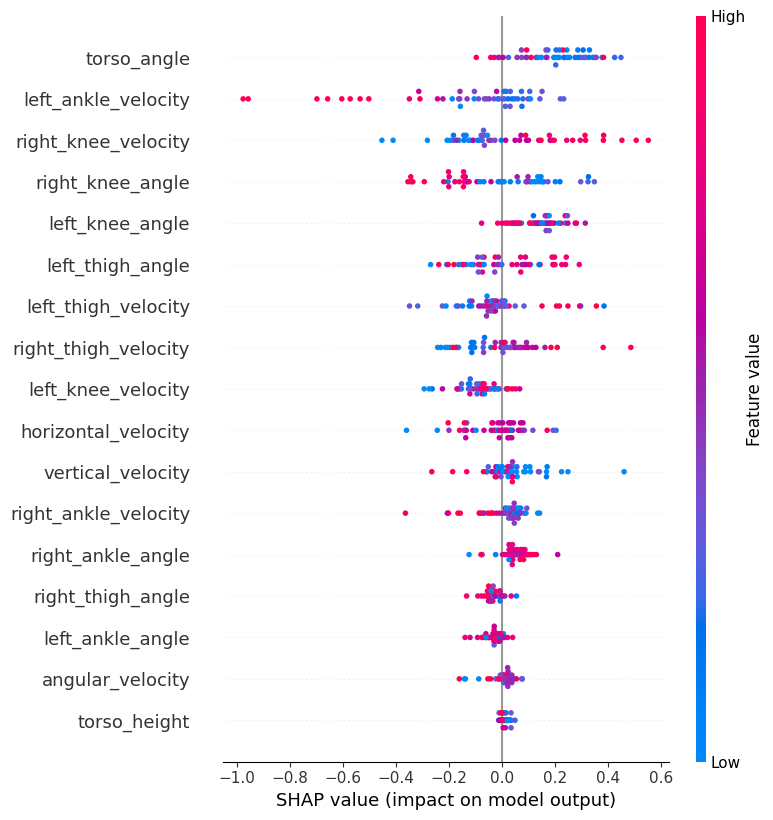

Displaying SHAP Summary for Action Dimension 4


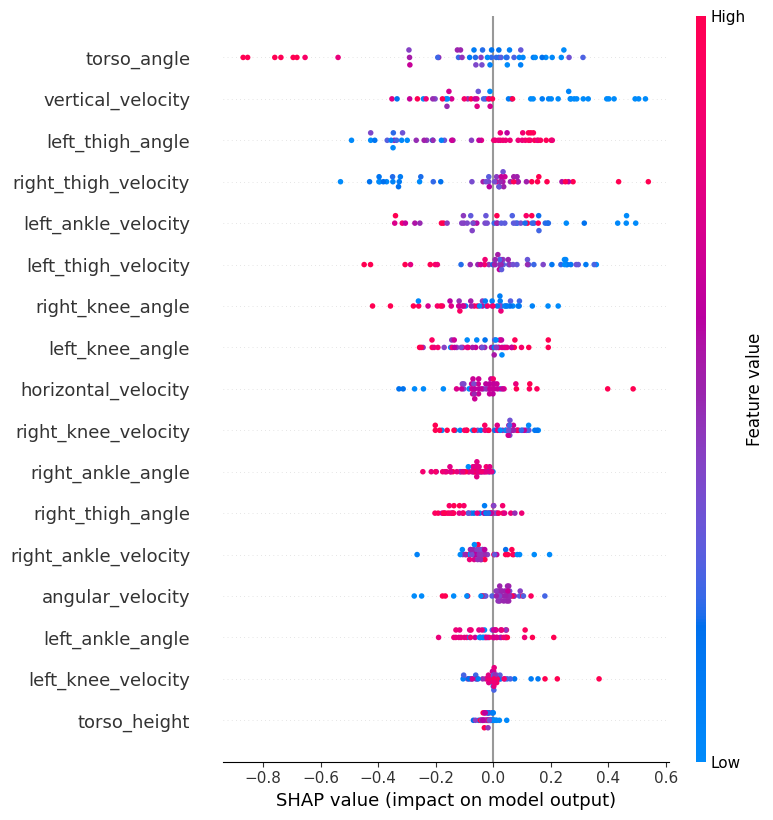

Displaying SHAP Summary for Action Dimension 5


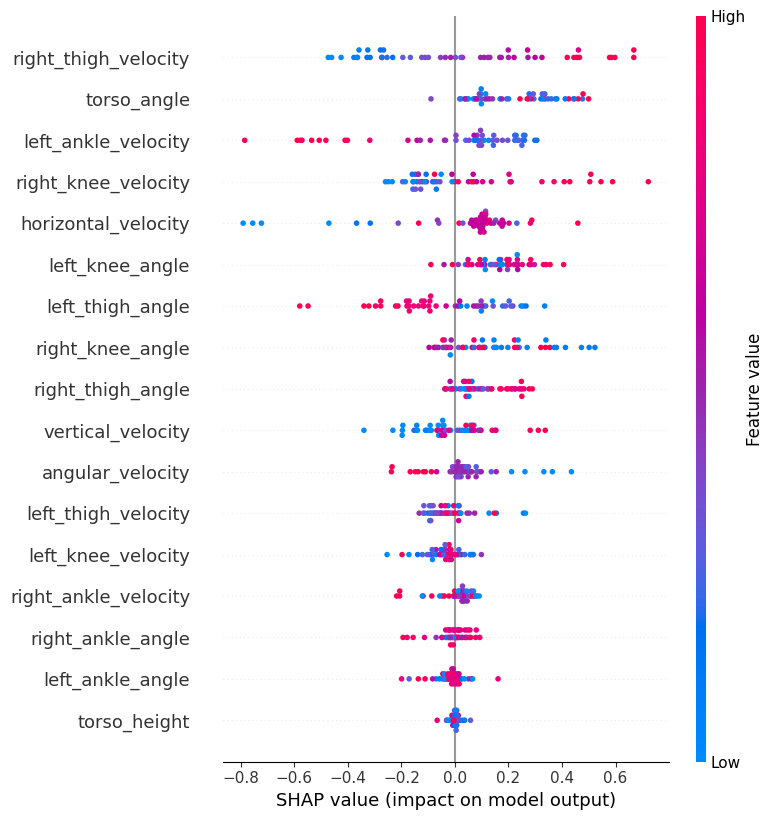

In [1]:
# In your Jupyter Notebook cell:

import pickle
import shap
import numpy as np
import matplotlib.pyplot as plt

# Load the precomputed SHAP results
output_file = "shap_output.pkl"  # Adjust path if necessary
with open(output_file, "rb") as f:
    data = pickle.load(f)

shap_values = data["shap_values"]
states_to_explain = data["states_to_explain"]
feature_names = data["feature_names"]

print("Loaded SHAP values with shape:", shap_values.values.shape)
print("States shape:", states_to_explain.shape)
print("Feature names:", feature_names)

# Create summary plots for each action dimension
ACTION_DIM = shap_values.values.shape[-1]  # Assuming shape is (samples, STATE_DIM, ACTION_DIM)
for action_idx in range(ACTION_DIM):
    print(f"Displaying SHAP Summary for Action Dimension {action_idx}")
    # Extract SHAP values for a specific action dimension
    action_shap = shap_values.values[:, :, action_idx]
    shap.summary_plot(action_shap, states_to_explain, feature_names=feature_names)
